<a href="https://colab.research.google.com/github/DrorNeumeier/MyPalindromeMaker/blob/main/Drors_Palindromes_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Come join me in creating palindromes
This palindrome maker uses a recursive tree lookup to find potential palindromes. It then uses an NLP model to to filter candidates. Options below allow you to pick a dictionary and a language context. For convenience all models are pre-trained but you can re-train them yourself in steps 4 and 5.
<br>To run the palindrome maker, execute the steps below in order

#Step1: setup
This step gets the code from github and installs any required libraries. It will take a minute or two.

In [1]:
#@title Run the cell by clicking the Play button below { display-mode: "form" }

import os
if not os.path.exists("MyPalindromeMaker"):
  !git clone https://github.com/DrorNeumeier/MyPalindromeMaker
else:
  !git -C MyPalindromeMaker pull 

#!git -C MyPalindromeMaker lfs pull
#!unzip MyPalindromeMaker/\*.zip 

!pip install transformers
!pip install wget


import random 
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
import torch
import tensorflow as tf
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import shutil
import wget

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print("setting up the GPU devices that we will use in training later")
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print("##################################################################")
    print("Can't find a GPU. You REALLY want a GPU for this.")
    print("Go click on the little arrow on the top right next to the RAM and Disk monitors")
    print("Select View Resources")
    print("See if a GPU shows up. I bet you it does not.")
    print("Now click on 'change runtime type' at the bottom")
    print("Under Hardware accelerator make sure you select a GPU")
    print("Try running this cell again")
    print("##################################################################")
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


steps_compleated = 1
print("\n\n\nContinue to the next step...")

Cloning into 'MyPalindromeMaker'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 295 (delta 43), reused 68 (delta 40), pack-reused 221
Receiving objects: 100% (295/295), 163.99 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (161/161), done.
Checking out files: 100% (37/37), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 37.9 MB/s 
     |████████████████████████████████| 163 kB 69.2 MB/s 
     |████████████████████████████████| 7.6 MB 64.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=700a977081d7ba790849ba3feae3d93c0bebb674e57fd5306b38838d31a07557
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

setting up the GPU devices that we will use in training later
Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4



Continue to the next step...


#Step2: The palindrome maker
This step builds my code to make palindromes. 


*   The function `makeDictionary` compiles all the words of the dictionary into a letter hierarchy tree.
Two such trees are made. One for all words forward and one for all words backwards.
*   The `makePalindrome` function picks a letter available to both dictionary trees, recursively navigating both trees letter by letter and banking words as it finds them.
*   The `makeGibberish` function constructs a nonsense sentence of a given length out of randomly picked words from the dictionary. Note that words are selected such that their lengths match the probability of word lengths in the language context (if you don't do this the NLP model will not train correctly. I learned this the hard way, save yourself some time).


In [2]:
#@title Run the cell by clicking the Play button below { display-mode: "form" }


import random
import time
import datetime
import numpy as np

try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"


def loadWords(filename):
  f=open(filename)
  words=f.readlines()
  words=[word.strip().lower() for word in words]
  backwardWords = [word[::-1] for word in words]

  return words, backwardWords

def loadSentences(filename):
  f=open(filename)
  sentences=f.readlines()
  sentences=[sentence.strip().lower() for sentence in sentences]

  return sentences


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def makeDictionary(wordList,currentString):

  #print("makeDictionary", currentString)

  ret={}
  ret["letters"] = {}

  letters = []
  newWordList=[]


  for word in wordList:
    if(word.startswith(currentString) and len(word)>len(currentString)):
      
      nextLetter=word[len(currentString)]
      newWordList.append(word)
      
      if nextLetter not in letters:
        letters.append(nextLetter)

  for letter in letters:
    ret["letters"][letter]=makeDictionary(newWordList, currentString+letter)

  if(currentString in wordList):
    ret["letters"][" "]={}

  return ret

def getDictionaryNode(dictionary, currentString):
  if len(currentString) == 0:
    return dictionary

  letter = currentString[0]
  currentString = currentString[1:]

  if letter not in dictionary["letters"].keys():
    return None

  return getDictionaryNode(dictionary["letters"][letter], currentString)


def makePalindrome(forwardDictionary, backwardDictionary, forwardString, backwardString, forwardList, backwardList, numberOfWords, printDebug=False):
  if printDebug:
    print(forwardList, forwardString,"...", backwardString, backwardList)
  
  forwardNode=getDictionaryNode(forwardDictionary, forwardString)
  backwardNode=getDictionaryNode(backwardDictionary, backwardString[::-1])

  if not forwardNode or not backwardNode:
    print(forwardList, forwardString,"...", backwardString, backwardList)
    print("Not a valid palindrome")
    return None

  if(len(forwardList)+len(backwardList) == numberOfWords-1 and (getDictionaryNode(forwardDictionary, forwardString+backwardString) != None and " " in getDictionaryNode(forwardDictionary, forwardString+backwardString)["letters"].keys())):
    forwardList.append(forwardString+backwardString)
    forwardString=""
    backwardString=""
    return forwardList+backwardList


  if(random.choice(list(forwardNode["letters"].keys()))==" "):
    forwardList.append(forwardString)
    forwardString=""
    forwardNode=forwardDictionary

  if(random.choice(list(backwardNode["letters"].keys()))==" "):
    backwardList.insert(0,backwardString)
    backwardString=""
    backwardNode=backwardDictionary

  if(len(forwardList)+len(backwardList) == numberOfWords and len(backwardString)==0 and len(forwardString)==0):
    return forwardList+backwardList

  if (len(forwardList)+len(backwardList) > numberOfWords):
      return None
  
  possibleLetters=(set(forwardNode["letters"].keys()) & set(backwardNode["letters"].keys())) - set(" ")
  possibleLetters = list(possibleLetters)

  #print(forwardNode["letters"].keys(), backwardNode["letters"].keys())
  #print(possibleLetters)

  if(len(possibleLetters)==0):
    return None

  
  random.shuffle(possibleLetters)
  for letter in possibleLetters:
    forwardString_=forwardString+letter
    backwardString_=letter+backwardString
    forwardList_= forwardList.copy()
    backwardList_=backwardList.copy()

    ret = makePalindrome(forwardDictionary, backwardDictionary, forwardString_, backwardString_, forwardList_, backwardList_, numberOfWords, printDebug=printDebug)
    if(ret):
      return ret

def getLanguageStats(words, sentences, printDebug=False):

  #how long are the sentences
  sentenceLenghts = []
  for sentence in sentences:
    wordCount = sentence.count(" ")
    sentenceLenghts.append(wordCount)

  if printDebug:
    print("Average sentence length", sum(sentenceLenghts)/len(sentenceLenghts))
    print("Sentence length histogram")
    counts, bins = np.histogram(sentenceLenghts)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()

  sentenceLenghtsCounts = {}
  for wordCount in sentenceLenghts:

    if wordCount not in sentenceLenghtsCounts.keys():
      sentenceLenghtsCounts[wordCount] = 0
  
    sentenceLenghtsCounts[wordCount] = sentenceLenghtsCounts[wordCount] + 1


  #how long are the words in the dictionary
  dictionaryWordLengths = []
  for word in words:
    dictionaryWordLengths.append(len(word))
  
  if printDebug:
    print("Average dictionary word length", sum(dictionaryWordLengths)/len(dictionaryWordLengths))
    print("Dictionary word length histogram")
    counts, bins = np.histogram(dictionaryWordLengths)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()

  dictionaryWordLengthCounts = {}
  for letterCount in dictionaryWordLengths:
    if letterCount <= 0:
      continue
    if letterCount not in dictionaryWordLengthCounts.keys():
      dictionaryWordLengthCounts[letterCount] = 0

    dictionaryWordLengthCounts[letterCount] = dictionaryWordLengthCounts[letterCount] + 1


  #how long are the words in the sentences
  sentencesWordLengths = []
  for sentence in sentences:
    words = sentence.split(" ")
    for word in words:
      sentencesWordLengths.append(len(word))
    
  if printDebug:
    print("Average sentence word length", sum(sentencesWordLengths)/len(sentencesWordLengths))
    print("Sentence word length histogram")
    counts, bins = np.histogram(sentencesWordLengths)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()

  sentenceWordLengthCounts = {}
  for letterCount in sentencesWordLengths:
    if letterCount <= 0:
      continue
    if letterCount not in sentenceWordLengthCounts.keys():
      sentenceWordLengthCounts[letterCount] = 0

    sentenceWordLengthCounts[letterCount] = sentenceWordLengthCounts[letterCount] + 1

  '''
  #how likely is each word to show up based on its length
  wordProbabilities = {}
  totalWordsInSentences = len(sentencesWordLengths)
  for word in words:
    numberOfWordsOfThisLength = sentenceWordLengthCounts[len(word)]
    probabilityOfAWordOfThisLength = numberOfWordsOfThisLength / totalWordsInSentences

    wordProbabilities[word] = probabilityOfAWordOfThisLength
  '''

  return sentenceLenghtsCounts, dictionaryWordLengthCounts, sentenceWordLengthCounts

def makeGibberish(N, words, sentences):

  ret = []

  #for easy access
  wordsByLength = {}
  for word in words:
    if len(word) not in wordsByLength.keys():
      wordsByLength[len(word)] = []
    
    wordsByLength[len(word)].append(word)


  #first lets get some stats on the language
    
  sentenceLenghtsCounts, dictionaryWordLengthCounts, sentenceWordLengthCounts = getLanguageStats(words, sentences)

  #just in case there is some crazy words in sentences with crazy lengths that are not in the dictionary
  badWordLengths = [l for l in sentenceWordLengthCounts.keys() if l not in wordsByLength.keys()]
  for badWordLength in badWordLengths:
    del sentenceWordLengthCounts[badWordLength]
  #print("badWordLengths", badWordLengths)

  retSentenceLengths = random.choices(list(sentenceLenghtsCounts.keys()), weights=list(sentenceLenghtsCounts.values()), k=N)

  #print(retSentenceLengths)

  for sentenceLength in retSentenceLengths:

    sentenceWordLengths = random.choices(list(sentenceWordLengthCounts.keys()), weights=list(sentenceWordLengthCounts.values()), k=sentenceLength)

    #print(sentenceWordLengths)

    sentence = []
    for wordLength in sentenceWordLengths:
      word = random.choice(wordsByLength[wordLength])
      #print(word)
      sentence.append(word)

    ret.append(" ".join(sentence))
  
  return ret



###################################################################
### This is code to train the NLP model
### Most of this code comes from various tutorials
###################################################################

def tokenizeSentences(tokenizer, sentences):
  inputIds = []
  attentionMasks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          truncation=True,
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          #padding=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
      #The tokenized IDs
      inputIds.append(encoded_dict['input_ids'])
      #A mask with zeros past the end of the sentence 
      attentionMasks.append(encoded_dict['attention_mask'])

  return inputIds, attentionMasks

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
steps_compleated = 2
print("Continue to the next step...")


Continue to the next step...


#Step 3: Choose your dictionary and language context
Select a dictionary from the drop downs to the right.
This will load a dictionary and language context combo. <br> We compiled some dictionaries/language contexts for you.

*   The English training sentence uses a 6000 sentence training set meant for grammar correction called [CoLA](https://nyu-mll.github.io/CoLA/)
*   The King Jame Bible is the King James Bible
*   Pulp Sci Fi comes from the [SciFi Stories Text Corpus](https://www.kaggle.com/datasets/jannesklaas/scifi-stories-text-corpus)
*   The complete works of Shakespeare are the complete works of Shakespeare
*   Wikipedia has been formatted in [this training set](https://www.kaggle.com/datasets/sjtulyf/wikipediasentences)
*   The JPS bible is the JPS bible

<br>

Once loaded you will see histograms for sentence and word lengths in the dictionary/context.<br>
The code will also try to download and install the pre-trained models to save time.









This dictionary has 58761 many words in it
This dictionary has 6023 sentences supporting it
Average sentence length 6.65615141955836
Sentence length histogram


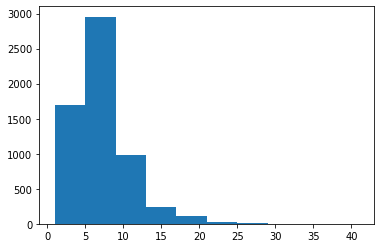

Average dictionary word length 8.313626384847092
Dictionary word length histogram


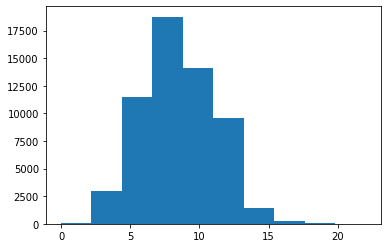

Average sentence word length 4.283325743282806
Sentence word length histogram


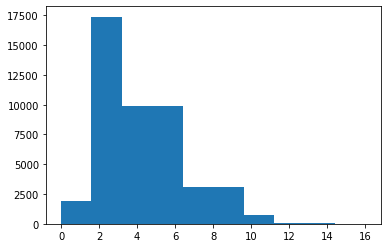

Loading dictionary English (common used words dictionary):eng this can take a minute or so
Dictionary is loaded.



Continue to the next step...


In [4]:
#@title Run the cell by clicking the Play button below { display-mode: "form" }


import matplotlib.pyplot as plt 
from urllib.error import HTTPError

try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"
assert steps_compleated >= 2, "Please go back and execute the steps in order from Step 2"

dictionaryName = "English (common used words dictionary):eng" #@param ["English (common used words dictionary):eng", "English (Crossword dictionary):eng2", "English (Scrabble dictionary):eng3", "The King James Bible:kjv", "Pulp Sci Fi:sci", "The compleate works of Shakespeare:sks", "All of Wikipedia:wiki", "A Scrabble dict and Wikipedia context:wiki2", "Jewish Publication Society Bible:jps"]
dictionaryPrefix = dictionaryName.split(":")[1]

words, backwardWords = loadWords("MyPalindromeMaker/dictionaries/%s_words.txt" % dictionaryPrefix)

sentences = loadSentences("MyPalindromeMaker/dictionaries/%s_sentences.txt" % dictionaryPrefix)

print("This dictionary has", len(words), "many words in it")
print("This dictionary has", len(sentences), "sentences supporting it")

sentenceLenghtsCounts, dictionaryWordLengthCounts, sentenceWordLengthCounts = getLanguageStats(words, sentences, printDebug=True)

print("Loading dictionary", dictionaryName, "this can take a minute or so")

forwardDictionary=makeDictionary(words, "")
backwardDictionary=makeDictionary(backwardWords, "")

print("Dictionary is loaded.")

if not os.path.exists("model_" + dictionaryPrefix):
  print("Looking for pre-trained model. this can take a minute or so")
  try:
    wget.download("https://palindromes.s3.amazonaws.com/model_" + dictionaryPrefix + ".zip", './model_' + dictionaryPrefix + ".zip")
  
    !unzip -o model_"$dictionaryPrefix".zip
    !rm model_"$dictionaryPrefix".zip
  
  except HTTPError:
    print("Can't download pre-trained model. But don't worry. You can train it yourself in steps 4 and 5")

steps_compleated = 3
print("\n\n\nContinue to the next step...")

#Let's make a random palindrome using the dictionary and context you just picked

You can tune the following parameters
*   `numberOfWordsInPalindrome`: the number of words in the final palindrome. "choose for me" will pick a number of words based on the probability histogram for that language context
*   `minimumPalindromeLength` sets the minimum palindrome length.
*   `palindromeSeedWord` starts the palindrome with this word

In [5]:
#@title Run the cell by clicking the Play button below { display-mode: "form" }


numberOfWordsInPalindrome = "choose for me" #@param ["choose for me", 2,3,4,5,6,7,8,9,10,15,20,30]
minimumPalindromLength = "3" #@param [2,3,4,5,6,7,8,9,10,15,20,30]
palindromeSeedWord = "" #@param {type:"string"}

try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"
assert steps_compleated >= 2, "Please go back and execute the steps in order from Step 2"
assert steps_compleated >= 3, "Please go back and execute the steps in order from Step 3"

if numberOfWordsInPalindrome == "choose for me":
  numberOfWordsInPalindrome = -1
numberOfWordsInPalindrome = int(numberOfWordsInPalindrome)
minimumPalindromLength = int(minimumPalindromLength)
palindromeSeedWord = palindromeSeedWord.strip()

if numberOfWordsInPalindrome < 0:
  sentenceLenghtsCounts_ = sentenceLenghtsCounts.copy()
  for l in list(sentenceLenghtsCounts_.keys()):
    if l < minimumPalindromLength:
      del sentenceLenghtsCounts_[l]

  #pick how many words the palindrome should have at random (based on how long sentences are in the languge)
  N = random.choices(list(sentenceLenghtsCounts_.keys()), weights=list(sentenceLenghtsCounts_.values()), k=1)[0]
else:
  N = numberOfWordsInPalindrome

print("making a palindrome of length", N)

if len(palindromeSeedWord) == 0:
  palindrome = makePalindrome(forwardDictionary, backwardDictionary, "", "", [], [], N, printDebug=True)
else:
  palindrome = makePalindrome(forwardDictionary, backwardDictionary, "", palindromeSeedWord[::-1], [palindromeSeedWord], [], N, printDebug=True)

if palindrome:
  print(" ".join(palindrome))
else:
  print("No valid palindrome found")

making a palindrome of length 13
[]  ...  []
[] s ... s []
[] st ... ts []
[] ste ... ets []
[] steg ... gets []
[] stel ... lets []
[] stell ... llets []
[] stella ... allets []
[] sten ... nets []
[] steno ... onets []
[] ster ... rets []
[] stera ... arets []
[] stere ... erets []
[] stee ... eets []
[] steel ... leets []
['steel'] f ... fleets []
['steel'] fl ... l ['fleets']
['steel'] flu ... ul ['fleets']
['steel'] flub ... bul ['fleets']
['steel'] fluo ... oul ['fleets']
['steel'] fluk ... kul ['fleets']
['steel'] flun ... nul ['fleets']
['steel'] flus ... sul ['fleets']
['steel'] fluf ... ful ['fleets']
['steel'] fly ... yl ['fleets']
['steel'] flyh ... hyl ['fleets']
['steel'] fle ... el ['fleets']
['steel'] fles ... sel ['fleets']
['steel'] flea ... ael ['fleets']
['steel', 'flea'] r ... rael ['fleets']
['steel', 'flea'] h ... hael ['fleets']
['steel'] flex ... xel ['fleets']
['steel', 'flex'] i ... ixel ['fleets']
['steel', 'flex', 'i'] p ... pixel ['fleets']
['steel', 'flex

#Now it is time to train the Natural Lang Processing model
We are going to use a Bidirectional Encoder Representations from Transformers (BERT for short) model.
BERT models are good at processing language. You can learn more about them [here](https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model).
We will be using one called [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification)
This BERT model is a classifier. That means it has a layer at the end that classifies the input into one of several ... well classifications. In our case we will have two classifications: good and bad. We use our language context to create the good sentences for the training set and the makeGibberish to create the bad sentences. Our classifiers learn to tell the difference between the real sentences and the gibberish ones.<br>
What we are doing is technically "fine tuning". The core BERT model is pre-trained (thank you Google) on A LOT of data and we don't have to touch that. We are only training the classifier layer at the bottom.

The next few steps are based on multiple tutorials and we are thankful to the many people who help make ML accessible by publishing their code. In particular see [BERT-fine-tuning](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) for in depth details on what we are doing here. 

The trained models were downloaded in the previous steps so you can skip the next 2 steps. But if you want to you can train the model yourself using this cell.<br>

##Step 4: Setup a training set

You can pick the size of the training set to use on the right. We recommend to go as high as the training set allows.<br>
This cell creates the training set. Step number 5 actually trains the model



In [10]:
#@title Run the cell below by clicking the Play button below { display-mode: "form" }


rebuildModelIfAlreadyThere = "yes" #@param ["yes", "no"]
trainingSetSize = "40000" #@param [5000, 10000, 20000, 30000, 40000]

trainingSetSize = int(trainingSetSize)
trainingSetSizeHalf = int(trainingSetSize/2)

try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"
assert steps_compleated >= 2, "Please go back and execute the steps in order from Step 2"
assert steps_compleated >= 3, "Please go back and execute the steps in order from Step 3"


if os.path.exists("model_%s" % dictionaryPrefix ) and rebuildModelIfAlreadyThere == "no":
  print("This model is already trained. You can skip to the next step")
else:

  print("First we need to create the training set")

  trainingListSentences = random.choices(sentences, k=trainingSetSizeHalf)
  trainingListLabels = [1] * (trainingSetSizeHalf)

  #print(sentenceLenghts)
  generatedSenteceLengths = makeGibberish(trainingSetSizeHalf, words, sentences)

  for sentence in generatedSenteceLengths:
    #just in case
    if True: #if len(sentence) < 64:
      trainingListSentences.append(sentence)
      trainingListLabels.append(0)

  print("Here is a real sentence")
  print("\"",trainingListSentences[0],"\"")
  print("\nAnd here is a gibirish sentence")
  print("\"",trainingListSentences[trainingSetSizeHalf], "\"")


  print("\nand here is the tokenized sentence")
  print('Tokenized: ', tokenizer.tokenize(trainingListSentences[0]))
  print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(trainingListSentences[0])))

  inputIds, attentionMasks = tokenizeSentences(tokenizer, trainingListSentences)
  # Convert the lists into tensors.
  inputIds = torch.cat(inputIds, dim=0)
  attentionMasks = torch.cat(attentionMasks, dim=0)
  trainingListLabels = torch.tensor(trainingListLabels)

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(inputIds, attentionMasks, trainingListLabels)

  # Create a 90-10 train-validation split.
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))
  print("\n\n")

  # For fine-tuning BERT it is recommended to use batch size of 16 or 32.
  batch_size = 32

  # Create the Data and Validation Loaders 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )

  #this is the actual model we will be training
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--in our case 2. GOOD/BAD. 
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  optimizer = torch.optim.AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

  # Number of training epochs. The BERT authors recommend between 2 and 4. 
  # This is probably too much. We will end training early if it looks like we are overfitting
  epochs = 4

  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

steps_compleated=4
print("Continue to next step")


First we need to create the training set
Here is a real sentence
" john is happy about the outcome "

And here is a gibirish sentence
" kin nun ah "

and here is the tokenized sentence
Tokenized:  ['john', 'is', 'happy', 'about', 'the', 'outcome']
Token IDs:  [2198, 2003, 3407, 2055, 1996, 9560]
36,000 training samples
4,000 validation samples





Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Continue to next step


##Step 5: Do the actual training
This will start the actual training of the model. We are training for four epochs even though we are probably overfitting after about two. One day we will fine tune this, but for now it works fine. <br>
This step can take a while. Go make yourself a cup of coffee.

In [11]:
#@title Run the cell below by clicking the Play button below { display-mode: "form" }


try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"
assert steps_compleated >= 2, "Please go back and execute the steps in order from Step 2"
assert steps_compleated >= 3, "Please go back and execute the steps in order from Step 3"
assert steps_compleated >= 4, "Please go back and execute the steps in order from Step 4"


if os.path.exists("model_%s" % dictionaryPrefix ) and rebuildModelIfAlreadyThere=="no":
  print("This model is already trained. You can skip to the next step")
else:

  # Set the seed value to create arbitrary randomness
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  avg_val_accuracy = 0

  # For each epoch...
  for epoch_i in range(0, epochs):

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

      #if epoch_i >= 2 and avg_val_accuracy > 0.99:
      #  print("Training accuracy is over %99 and it's been 2 epochs. We can call it quits early.")
      #  break

      print('Training...')

      t0 = time.time()

      total_train_loss = 0

      # Put the model into training mode.
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader and copy to the GPU using the 'to' method
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass.
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          loss, logits = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels, return_dict = False)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.4f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels, return_dict = False)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.4f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  # Create a DataFrame from our training statistics.
  pd.set_option('precision', 2)
  df_stats = pd.DataFrame(data=training_stats)
  df_stats = df_stats.set_index('epoch')

  print(df_stats)

  print("saving the model")
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained("model_%s" % dictionaryPrefix)
  tokenizer.save_pretrained("model_%s" % dictionaryPrefix)


steps_compleated = 5
print("Continue to next step")


======== Epoch 1 / 4 ========
Training...


KeyboardInterrupt: ignored

#Step 6: Let's make some palindromes!
Now that we have both the palindrome maker and the model that can filter out gibberish we can find palindromes by generating a lot of palindromes and running them through the model.

You can tune the following parameters
*   `numberOfWordsInPalindrome`: the number of words in the final palindrome. "choose for me" will pick a number of words based on the probability histogram for the selected language context
*   `desiredNumberOfPalindromes`: the number of acceptable palindromes that it generates. "find the best" will keep going until the `ROUND_LIMIT` is reached
*   `minimumPalindromeLength` sets the minimum palindrome length.
*   `ROUND_LIMIT`caps the number of cycles it will try
*   `palindromeSeedWord` starts the palindrome with this word

The palindromes are listed with a grade from the model. The larger the number, the closer the model thinks this is to a real sentence.


In [8]:
#@title Run the cell by clicking the Play button below { display-mode: "form" }


numberOfWordsInPalindrome = "choose for me" #@param ["choose for me", 2,3,4,5,6,7,8,9,10,15,20,30]
desiredNumberOfPalindromes = "find the best" #@param ["find the best", 1, 5, 10, 20]
minimumPalindromLength = "3" #@param [2,3,4,5,6,7,8,9,10,15,20,30]
ROUND_LIMIT = "100000" #@param [25000, 50000, 100000, 500000, 1000000]
palindromeSeedWord = "" #@param {type:"string"}

try:
  steps_compleated
except:
  steps_compleated = 0
assert steps_compleated >= 1, "Please go back and execute the steps in order from Step 1"
assert steps_compleated >= 2, "Please go back and execute the steps in order from Step 2"
assert steps_compleated >= 3, "Please go back and execute the steps in order from Step 3"
assert os.path.exists("model_%s" % dictionaryPrefix), "model directory not found. Are you sure you did all the steps? You might need to train this model first."

if numberOfWordsInPalindrome == "choose for me":
  numberOfWordsInPalindrome = -1
numberOfWordsInPalindrome = int(numberOfWordsInPalindrome)
if desiredNumberOfPalindromes == "find the best":
  desiredNumberOfPalindromes = 1000
else:
  desiredNumberOfPalindromes = int(desiredNumberOfPalindromes)
minimumPalindromLength = int(minimumPalindromLength)
ROUND_LIMIT = int(ROUND_LIMIT)
palindromeSeedWord = palindromeSeedWord.strip()

tokenizer = BertTokenizer.from_pretrained("model_%s" % dictionaryPrefix)
model_loaded = BertForSequenceClassification.from_pretrained("model_%s" % dictionaryPrefix)
model_loaded = model_loaded.to(device)

palindromesTried = set()
palindromesWithStrength = []
closeCalls = []
duplicateRounds = 0

sentenceLenghtsCounts_ = sentenceLenghtsCounts.copy()
for l in list(sentenceLenghtsCounts_.keys()):
  if l < minimumPalindromLength:
    del sentenceLenghtsCounts_[l]

print("Making palindromes using dictionary:", dictionaryName)

i = 0
while len(palindromesWithStrength) < desiredNumberOfPalindromes:

  i = i + 1
  if i%1000 == 0:
    print("...I have tried %i palindromes (%i rounds) and found %i that pass the language model. My duplication ratio is %f" % (len(palindromesTried), i, len(palindromesWithStrength), duplicateRounds/i))

  if i>ROUND_LIMIT:
    print("Reached round limit")
    break

  #make a palindrome
  if numberOfWordsInPalindrome > 0:
    N = int(numberOfWordsInPalindrome)
  else:
    N = random.choices(list(sentenceLenghtsCounts_.keys()), weights=list(sentenceLenghtsCounts_.values()), k=1)[0]
  
  if len(palindromeSeedWord) == 0:
    palindrome = makePalindrome(forwardDictionary, backwardDictionary, "", "", [], [], N)
  else:
    palindrome = makePalindrome(forwardDictionary, backwardDictionary, "", palindromeSeedWord[::-1], [palindromeSeedWord], [], N)

  if palindrome == None:
    print("No valid palindromes left. Removing length %i as a valid choice" % N)
    del sentenceLenghtsCounts_[N]
    if len(sentenceLenghtsCounts_) == 0:
      print("No more lengths left. Time to quit")
      break

    continue

  sentence = " ".join(palindrome)

  if sentence in palindromesTried:
    #print(sentence, "already tried it. Continue")
    duplicateRounds = duplicateRounds + 1
    continue
  else:
    palindromesTried.add(sentence)

  #now run it through the model to see if it a sensible sentence
  inputIds, attentionMasks = tokenizeSentences(tokenizer, [sentence])
  inputId = inputIds.pop()
  attentionMask = attentionMasks.pop()

  inputId = torch.LongTensor(inputId)
  attentionMask = torch.LongTensor(attentionMask)
  
  inputId = inputId.to(device)
  attentionMask = attentionMask.to(device)

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_loaded(inputId, token_type_ids=None, attention_mask=attentionMask)

  logits = outputs[0]
  index = logits.argmax()
  categorizationStrength = logits.max().item() - logits.min().item()
  
  if index == 1 :
      print("\n",sentence, categorizationStrength)

      palindromesWithStrength.append((sentence, categorizationStrength))
      palindromesWithStrength.sort(key = lambda x: x[1], reverse=True)

      print("Top contenders", palindromesWithStrength[:5])
  else:
      if categorizationStrength < 5:
        closeCalls.append((sentence, categorizationStrength))
        print("#######FAILED but close:", sentence, -categorizationStrength)
      pass


print("-----------------------------------")
palindromesWithStrength.sort(key = lambda x: x[1], reverse=True)
closeCalls.sort(key = lambda x: x[1])

for sentence in palindromesWithStrength:
  print(sentence[0], " - ", sentence[1])

print("-----------------------------------")
print("honorable mentions")
for sentence in closeCalls:
  print(sentence[0], " - ", sentence[1])



Making palindromes using dictionary: English (common used words dictionary):eng

  hanna vases oppose savannah 3.5404019355773926
Top contenders [(' hanna vases oppose savannah', 3.5404019355773926)]
#######FAILED but close: pulled dell up -1.784495234489441

 jarred named demander raj 7.6212334632873535
Top contenders [('jarred named demander raj', 7.6212334632873535), (' hanna vases oppose savannah', 3.5404019355773926)]

 males oppose lam  5.710814714431763
Top contenders [('jarred named demander raj', 7.6212334632873535), ('males oppose lam ', 5.710814714431763), (' hanna vases oppose savannah', 3.5404019355773926)]
...I have tried 988 palindromes (1000 rounds) and found 3 that pass the language model. My duplication ratio is 0.011000

 harasses opposes sarah 9.345848083496094
Top contenders [('harasses opposes sarah', 9.345848083496094), ('jarred named demander raj', 7.6212334632873535), ('males oppose lam ', 5.710814714431763), (' hanna vases oppose savannah', 3.5404019355773926)

KeyboardInterrupt: ignored